# $R_t$ and $k_t$ Negative-Binomial Plots of Number of Secondary Cases

This notebook contains the code for plotting the distribution of number of secondary cases along with their Negative-Binomial fits. As such, the code still requires a bit of manual adaptation for each experiment. So the code here corresponds to the code to generate the plots in the paper.


In [1]:
%load_ext autoreload
%autoreload 2
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [2]:
import itertools
import numpy as np
from scipy import stats as sps
import scipy.optimize
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from lib.experiment import load_summary, load_config
from lib import plot as lib_plot
from lib import rt_nbinom  # Module for NB fit of Rt/kt

---

## Experiment in continued lockdown

GER-TU: 4
--------------------
GER: simulation starts on 2020-03-12, lockdown starts on 2020-03-23
-- Plot daily Rt over time...
Estimating r=48/48, interval=[936.00, 1056.00]...
Save: plots/daily-nbinom-rts-continued-lockdown-GER-TU_extended_lockdown_weeks=4-daily-Rt.pdf

GER-TU: 100
--------------------
GER: simulation starts on 2020-03-12, lockdown starts on 2020-03-23
-- Plot daily Rt over time...
Estimating r=48/48, interval=[936.00, 1056.00]...
Save: plots/daily-nbinom-rts-continued-lockdown-GER-TU_extended_lockdown_weeks=100-daily-Rt.pdf

GER-KL: 4
--------------------
GER: simulation starts on 2020-03-15, lockdown starts on 2020-03-23
-- Plot daily Rt over time...
Estimating r=48/48, interval=[864.00, 984.00]...
Save: plots/daily-nbinom-rts-continued-lockdown-GER-KL_extended_lockdown_weeks=4-daily-Rt.pdf

GER-KL: 100
--------------------
GER: simulation starts on 2020-03-15, lockdown starts on 2020-03-23
-- Plot daily Rt over time...
Estimating r=48/48, interval=[864.00, 984.00

KeyboardInterrupt: 

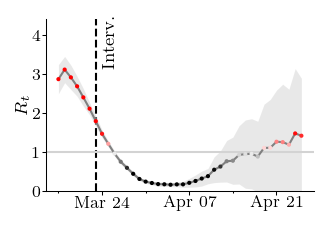

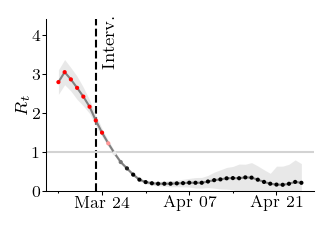

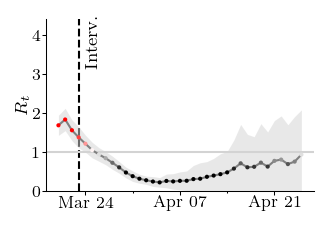

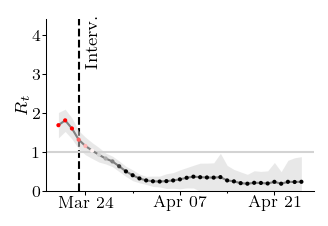

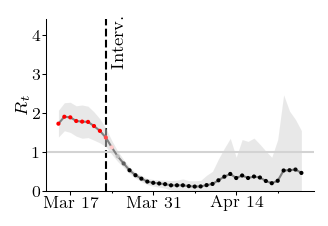

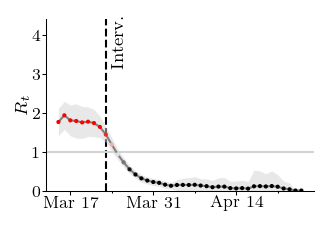

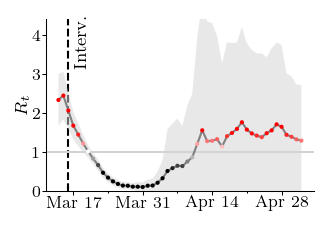

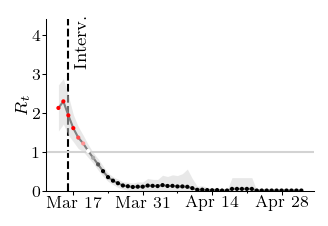

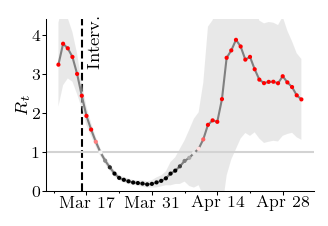

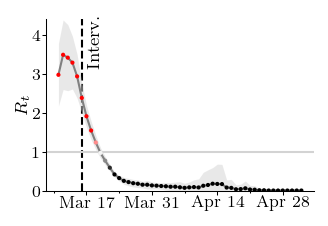

In [7]:
def plot_daily_rt(area, num_weeks, xtick_interval, plot_rt=True, plot_pmf=True):
    config = load_config(f'lib/settings/{area}_config.py')
    country = config.country
    area = config.area
    
    print(f"{country}-{area}: {num_weeks}")
    print('-'*20)
    # Load the experiment summary
    summary_name = f'continued-lockdown-{country}-{area}/continued-lockdown-{country}-{area}-extended_lockdown_weeks={num_weeks}.pk'
    result = load_summary(summary_name)
    # Extract the lockdown start time for the country
    country_code = result.metadata.country
    lockdown = config.calibration_lockdown_dates
    print((f"{country_code}: simulation starts on {result.metadata.start_date}, "
           f"lockdown starts on {lockdown['start']}"))
    # Plot daily Rt over time
    if plot_rt:
        print('-- Plot daily Rt over time...')
        plotter = lib_plot.Plotter()
        plotter.plot_daily_nbinom_rts(
            result=result,
            slider_size=24.0, window_size=24.*5, end_cutoff=24.*7,
            ymax=4.4,
#             lockdown_label='Interventions', 
#             lockdown_label_y=2.7,
#             figsize=(2.65, 1.9),
            lockdown_label='Interv.', 
            lockdown_label_y=3.2,
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV,
            lockdown_at=pd.to_datetime(lockdown['start']), 
            lockdown_xshift=1.1 * result.summary.max_time / 1560.0,
            xtick_interval=xtick_interval[country][area],
            figformat='neurips-double',
            filename=f"{result.metadata.experiment_info}_{result.metadata.simulation_info}-daily-Rt"
    )
    # Plot 2ndary cases distributions
    if plot_pmf:
        print('-- Plot 2ndary cases distributions...')
        if num_weeks == 100:
            t0_range=[0.0 * 24,   # the week before lockdown
                      15.0 * 24,  # right after start of lockdown
                     ]
            window_size=10.0*24
            label_range=['pre-lockdown',
                         'in-lockdown'
                        ]
        else:
            t0_range=[0.0 * 24,   # the week before lockdown
                      11.0 * 24,  # right after start of lockdown
                      38.0 * 24   # right after end of lockdown
                     ]
            window_size=7.0*24
            label_range=['pre-lockdown',
                         'in-lockdown',
                         'post-lockdown'
                        ]
        plotter = lib_plot.Plotter()
        plotter.plot_nbinom_distributions(
            result=result,
            x_range=np.arange(0, 20),
            t0_range=t0_range,
            window_size=window_size,
            label_range=label_range,
            ymax=0.85,
#             figsize=lib_plot.FIG_SIZE_NEURIPS_TRIPLE_TALL,
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV,
            figformat='neurips-double',
            filename=f"{result.metadata.experiment_info}_{result.metadata.simulation_info}-pmf"
        )
    print()


places = ['tuebingen', 'kaiserslautern', 'ruedesheim', 'locarno', 'bern', 'jura']


xtick_interval = {
    'GER': {'RH': 2, 'TU': 2, 'KL': 2},
    'CH': {'BE': 2, 'JU': 2, 'TI': 2},
}

for area in places:
    for num_weeks in [4, 100]:
        plot_daily_rt(area, num_weeks, xtick_interval, plot_rt=True, plot_pmf=False)



In [ ]:
# Crop pdf margins
!bash crop_pdfs.sh plots/daily-nbinom-rts-*.pdf
!bash crop_pdfs.sh plots/prob-secondaryCases-*.pdf

---

Custom plot parameter values for GER-RH

In [9]:
summary_name = 'continued-lockdown-GER-RH/continued-lockdown-GER-RH-extended_lockdown_weeks=4.pk'
config = load_config(f'lib/settings/ruedesheim_config.py')

# Load the experiment summary
result = load_summary(summary_name)

# Extract the lockdown start time for the country
country_code = result.metadata.country
lockdown = config.calibration_lockdown_dates
print((f"{country_code}: simulation starts on {result.metadata.start_date}, "
       f"lockdown starts on {lockdown['start']}"))

plotter = lib_plot.Plotter()

GER: simulation starts on 2020-03-10, lockdown starts on 2020-03-23


In [10]:
t0_range = [
    1.0 * 24,   # the week before lockdown
    15.0 * 24,  # right after start of lockdown
    38.0 * 24   # right after end of lockdown
]
window_size = 10.0*24
label_range = [
    'pre-lockdown',
    'in-lockdown',
    'post-lockdown'
]
x_range = np.arange(0, 20)

In [11]:
interval_range = [(t0, t0 + window_size) for t0 in t0_range]
df = plotter._compute_nbinom_distributions(result=result, x_range=x_range, interval_range=interval_range)

In [13]:
plotter = lib_plot.Plotter()
plotter.plot_nbinom_distributions(
    result=result,
    df=df,
    x_range=x_range,
    t0_range=t0_range,
    window_size=window_size,
    label_range=label_range,
    ymax=0.85,
    figsize=lib_plot.FIG_SIZE_NEURIPS_TRIPLE_TALL,
    figformat='neurips-double',
    filename=f"{result.metadata.experiment_info}_{result.metadata.simulation_info}-pmf"
)

# Crop pdf margins
!bash crop_pdfs.sh plots/prob-secondaryCases-*.pdf

Save: plots/prob-secondaryCases-continued-lockdown-GER-RH_extended_lockdown_weeks=4-pmf-0-pre-lockdown.pdf
Save: plots/prob-secondaryCases-continued-lockdown-GER-RH_extended_lockdown_weeks=4-pmf-1-in-lockdown.pdf
Save: plots/prob-secondaryCases-continued-lockdown-GER-RH_extended_lockdown_weeks=4-pmf-2-post-lockdown.pdf
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.
PDFCROP 1.38, 2012/11/02 - Copyright (c) 2002-2012 by Heiko Oberdiek.
==> 1 page written on `tmp.pdf'.


## During contact tracing

CH-TI:
--------------------
CH: simulation starts on 2021-01-01, lockdown starts on 2020-03-16
-- Plot daily Rt over time...
Estimating r=48/48, interval=[2448.00, 2616.00]...
Save: plots/daily-nbinom-rts-tracing-CH-TI-daily-Rt.pdf
-- Plot 2ndary cases distributions...
Save: plots/prob-secondaryCases-tracing-CH-TI-pmf-0-during-tracing.pdf

CH-BE:
--------------------


KeyboardInterrupt: 

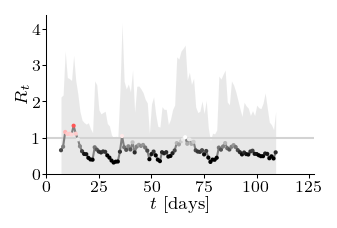

In [14]:
def plot_daily_rt_tracing(area, plot_rt=True, plot_pmf=True):
    config = load_config(f'lib/settings/{area}_config.py')
    country = config.country
    area = config.area
    
    print(f"{country}-{area}:")
    print('-'*20)
    # Load the experiment summary
    summary_name = f'tracing-{country}-{area}/tracing-{country}-{area}-tracing=isolate+test-'\
                  'delay=48.0-contacts_tested=100000-test_policy=basic.pk'
        
    result = load_summary(summary_name)
    # Extract the lockdown start time for the country
    country_code = result.metadata.country
    lockdown = config.calibration_lockdown_dates
    print((f"{country_code}: simulation starts on {result.metadata.start_date}, "
           f"lockdown starts on {lockdown['start']}"))
    # Plot daily Rt over time
    if plot_rt:
        print('-- Plot daily Rt over time...')
        plotter = lib_plot.Plotter()
        df = plotter._estimate_daily_nbinom_rts(result, slider_size=24.0, window_size=24.*7, end_cutoff=24.*10)
        
        plotter.plot_daily_nbinom_rts(
            result=result, 
            filename=f"{result.metadata.experiment_info}-daily-Rt",
            df = df, # <<<<<<<<<<<<
            slider_size=24.0, window_size=24.*7, end_cutoff=24.*10,
            cmap_range=(0.5, 1.5),
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
            figformat='neurips-double',
            ymax=4.4,
            xlim=(0, 127),
            x_axis_dates=False,
            subplots_adjust={'bottom':0.2, 'top': 0.98, 'left': 0.12, 'right': 0.96},
        )        
        
    # Plot 2ndary cases distributions
    if plot_pmf:
        print('-- Plot 2ndary cases distributions...')
        
        t0_range = [50 * 24.0] # after 50 days
        window_size = 10.0*24
        label_range = ['during-tracing']
        
        plotter = lib_plot.Plotter()
        plotter.plot_nbinom_distributions(
            result=result,
            x_range=np.arange(0, 20),
            t0_range=t0_range,
            window_size=window_size,
            label_range=label_range,
            ymax=0.85,
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV,
            figformat='neurips-double',
            filename=f"{result.metadata.experiment_info}-pmf"
        )
    print()

        
        
plot_daily_rt_tracing('locarno', plot_rt=True, plot_pmf=True)
plot_daily_rt_tracing('bern', plot_rt=True, plot_pmf=True)
plot_daily_rt_tracing('jura', plot_rt=True, plot_pmf=True)
plot_daily_rt_tracing('tuebingen', plot_rt=True, plot_pmf=True)
plot_daily_rt_tracing('kaiserslautern', plot_rt=True, plot_pmf=True)
plot_daily_rt_tracing('ruedesheim', plot_rt=True, plot_pmf=True)


# Crop pdf margins
!bash crop_pdfs.sh plots/daily-nbinom-rts-*.pdf
!bash crop_pdfs.sh plots/prob-secondaryCases-*.pdf

## K groups 

In [15]:
def plot_daily_rt_kgroups(area, plot_rt=True, plot_pmf=True):
    config = load_config(f'lib/settings/{area}_config.py')
    country = config.country
    area = config.area
    
    print(f"{country}-{area}:")
    print('-'*20)
    # Load the experiment summary
    summary_name = f'k-groups-{country}-{area}-K_groups=2.pk'
        
    result = load_summary(summary_name)
    # Extract the lockdown start time for the country
    country_code = result.metadata.country
    lockdown = config.calibration_lockdown_dates
    print((f"{country_code}: simulation starts on {result.metadata.start_date}, "
           f"lockdown starts on {lockdown['start']}"))
    # Plot daily Rt over time
    if plot_rt:
        print('-- Plot daily Rt over time...')
        plotter = lib_plot.Plotter()
        df = plotter._estimate_daily_nbinom_rts(result, slider_size=24.0, window_size=24.*7, end_cutoff=24.*10)
        
        plotter.plot_daily_nbinom_rts(
            result=result, 
            filename=f"{result.metadata.experiment_info}-daily-Rt",
            df = df, # <<<<<<<<<<<<
            slider_size=24.0, window_size=24.*7, end_cutoff=24.*10,
            cmap_range=(0.5, 1.5),
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV, 
            figformat='neurips-double',
            lockdown_label='Interv.', 
            lockdown_label_y=3.2,
            lockdown_at=pd.to_datetime(lockdown['start']), 
            lockdown_xshift=1.1 * result.summary.max_time / 1560.0,
            ymax=4.4,
        )        
            
    # Plot 2ndary cases distributions
    if plot_pmf:
        print('-- Plot 2ndary cases distributions...')
        
        t0_range = [50 * 24.0] # after 50 days
        window_size = 10.0*24
        label_range = ['during-tracing']
        
        plotter = lib_plot.Plotter()
        plotter.plot_nbinom_distributions(
            result=result,
            x_range=np.arange(0, 20),
            t0_range=t0_range,
            window_size=window_size,
            label_range=label_range,
            ymax=0.85,
            figsize=lib_plot.FIG_SIZE_FULL_PAGE_TRIPLE_ARXIV,
            figformat='neurips-double',
            filename=f"{result.metadata.experiment_info}-pmf"
        )
    print()

        
        
plot_daily_rt_kgroups('locarno', plot_rt=True, plot_pmf=True)
plot_daily_rt_kgroups('bern', plot_rt=True, plot_pmf=True)
plot_daily_rt_kgroups('jura', plot_rt=True, plot_pmf=True)
plot_daily_rt_kgroups('tuebingen', plot_rt=True, plot_pmf=True)
plot_daily_rt_kgroups('kaiserslautern', plot_rt=True, plot_pmf=True)
plot_daily_rt_kgroups('ruedesheim', plot_rt=True, plot_pmf=True)


# Crop pdf margins
!bash crop_pdfs.sh plots/daily-nbinom-rts-*.pdf
!bash crop_pdfs.sh plots/prob-secondaryCases-*.pdf

CH-TI:
--------------------


FileNotFoundError: [Errno 2] No such file or directory: 'summaries/k-groups-CH-TI-K_groups=2.pk'